In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)

In [2]:
from data import load_data

(x_train, y_train), (x_test, y_test) = load_data()

In [3]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [4]:
from sklearn.linear_model import SGDClassifier

sgd_model = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_model.fit(x_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=-inf, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [5]:
test_sample_idx = np.where(y_train_5 == True)[0][:5]
test_sample = x_train[test_sample_idx]
sgd_model.predict(test_sample)

array([ True,  True,  True,  True,  True])

In [6]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_model, x_train, y_train_5, cv=3, scoring='accuracy')

array([0.9633 , 0.95695, 0.9146 ])

In [7]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(x_train, y_train_5):
    clone_clf = clone(sgd_model)
    x_train_folds = x_train[train_index]
    y_train_folds = (y_train_5[train_index])
    x_test_fold = x_train[test_index]
    y_test_fold = (y_train_5[test_index])

    clone_clf.fit(x_train_folds, y_train_folds)
    y_pred = clone_clf.predict(x_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9633
0.95695
0.9146


In [8]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [9]:
never_5_model = Never5Classifier()
cross_val_score(never_5_model, x_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

In [10]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_model, x_train, y_train_5, cv=3)

In [11]:
from sklearn.metrics import confusion_matrix

train_cm = confusion_matrix(y_train_5, y_train_pred)
print(train_cm)

df_train_cm = pd.DataFrame(train_cm, 
    columns=['predict negative', 'predict positive'], 
    index=['actual negative', 'actual positive'])
df_train_cm

[[52336  2243]
 [ 1060  4361]]


,predict negative,predict positive
actual negative,52336,2243
actual positive,1060,4361


$precision = \frac{TP}{TP + FP}$

In [12]:
from sklearn.metrics import precision_score

precision = precision_score(y_train_5, y_train_pred)
print("precision = {}".format(precision))
print(4071 / (1162 + 4071))

precision = 0.6603573591762568
0.7779476399770686


$recall = \frac{TP}{TP + FN}$

In [13]:
from sklearn.metrics import recall_score

recall = recall_score(y_train_5, y_train_pred)
print("recall = {}".format(recall))
print(4071 / (4071 + 1350))

recall = 0.8044641210108836
0.7509684560044272


$F_1 score = \frac{2}{\frac{1}{precision} + \frac{1}{recall}}$

In [14]:
from sklearn.metrics import f1_score

f1 = f1_score(y_train_5, y_train_pred)
print("f1 = {}".format(f1))
print(2 / (1 / precision + 1 / recall))

f1 = 0.7253222453222454
0.7253222453222453


In [15]:
perfect_cm = confusion_matrix(y_train_5, y_train_5)
print(perfect_cm)

df_perfect_cm = pd.DataFrame(perfect_cm, 
    columns=['predict negative', 'predict positive'], 
    index=['actual negative', 'actual positive'])
df_perfect_cm

[[54579     0]
 [    0  5421]]


,predict negative,predict positive
actual negative,54579,0
actual positive,0,5421


In [16]:
y_scores = sgd_model.decision_function(x_train[:5])
print(y_scores)

[  57392.7316778  -360101.01414858 -623702.82013464 -274142.95448726
 -409607.45769158]


In [17]:
y_scores = cross_val_predict(sgd_model, x_train, y_train_5, cv=3, method='decision_function')

In [18]:
y_scores.shape

(60000,)

In [19]:
if y_scores.ndim == 2:
    y_scores = y_scores[:, 1]

In [20]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

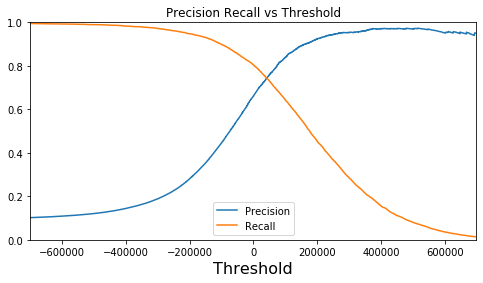

In [21]:
plt.figure(figsize=(8, 4))
plt.plot(thresholds, precisions[:-1], label="Precision")
plt.plot(thresholds, recalls[:-1], label="Recall")
plt.xlabel("Threshold", fontsize=16)
plt.legend(loc='lower center')
plt.ylim([0, 1])
plt.xlim([-700000, 700000])
plt.title("Precision Recall vs Threshold")
plt.show()

In [22]:
y_train_pred_90 = (y_scores > 70000)

In [23]:
precision_score(y_train_5, y_train_pred_90)

0.7909509844993716

In [24]:
recall_score(y_train_5, y_train_pred_90)

0.6965504519461354

precision vs recall

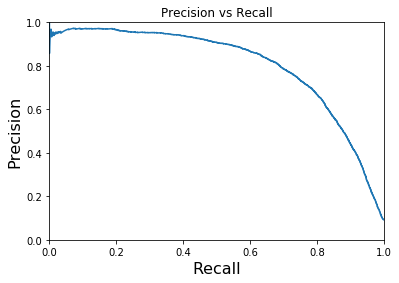

In [25]:
plt.figure()
plt.plot(recalls, precisions)
plt.xlabel("Recall", fontsize=16)
plt.ylabel("Precision", fontsize=16)
plt.axis([0, 1, 0, 1])
plt.title("Precision vs Recall")
plt.show()

ROC

In [26]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

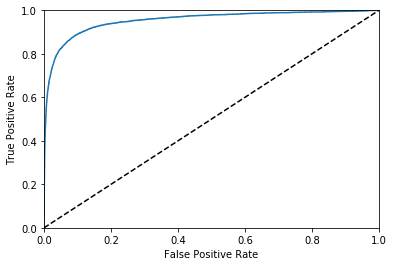

In [27]:
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [28]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9536789698168869

In [29]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=10, random_state=42)
y_probas_forest = cross_val_predict(rf_model, x_train, y_train_5, cv=3, method='predict_proba')

In [30]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

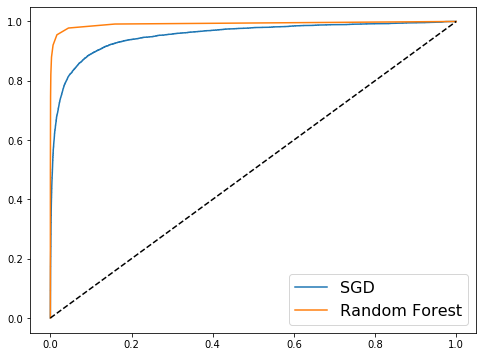

In [31]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="SGD")
plt.plot(fpr_forest, tpr_forest, label="Random Forest")
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(loc='lower right', fontsize=16)
plt.show()

In [32]:
roc_auc_score(y_train_5, y_scores_forest)

0.9920527492698306

In [33]:
y_train_pred_forest = cross_val_predict(rf_model, x_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.986046511627907

In [34]:
recall_score(y_train_5, y_train_pred_forest)

0.8212506917542889